# Negative News Neural Nets Project: Classifying Adverse Media Articles using Machine Learning Algorithms

Just use pipenv install to install all the neede packages in Pipfile. You can read all about pipenv at https://pipenv.pypa.io/en/latest/

Installing nltk packages will be easy, just look at the error to understand what needs to be downloaded using nltk.download(...). I have already provided the download code for punkt package and I don't think anything is required beside that.

## Dataset Preparation

Before doing any EDA, null value imputation, necessary dataset checks etc, we need to form the whole training dataset by combining the AM and NAM articles together. The latter one will include the random articles as well.

Let's begin with importing necessary/potentially useful stuff... Some of them below may not be used at all in the future, so the list below is tentative.

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

# For regular expressions
import re

# For handling strings
import string



In [3]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score, f1_score, confusion_matrix
import joblib

import scipy


For nlp to work you need to 
`pipenv shell`
and then
`python -m spacy download en_core_web_sm`

in the terminal/command line

In [4]:
# Uncomment this if you're using linux
!ls 

Data-PreprocessingBaselines.ipynb Pipfile.lock
Pipfile


In [5]:
# Let's get an overview of what our folder contains..
#!dir

We can see that the data required are in zipped format. Let's read them with pandas.

In [6]:
am = pd.read_csv('../../adverse_media_training.csv')
nam = pd.read_csv('../../non_adverse_media_training.csv')

Let's check the labels in both datasets. We may(/will :)) encounter some typos among them.

In [7]:
print(am.label.unique())
print()
print(am.label.value_counts())

[nan 'am' 'delete' 'delete        ' 'random' 'nam' 'doubt' 'neither'
 'am, doubt' 'am ']

am                391
delete             32
nam                18
random             12
doubt               5
delete              2
neither             2
am, doubt           1
am                  1
Name: label, dtype: int64


In [8]:
print(nam.label.unique())
print()
print(nam.label.value_counts())

['nam' nan 'am' 'neither' 'random' 'doubt' 'delete']

nam        285
am          19
doubt       13
delete       9
neither      7
random       3
Name: label, dtype: int64


Both datasets are not pure in their essence. We need to transfer some rows between them and drop the unnecessary rows having labels such as 'delete', 'neither' etc.

In [9]:
# Creating the AM dataset for train
am_confirmed = am.loc[(am.label == 'am') | (am.label == 'am ')]
am_confirmed = pd.concat([am_confirmed, nam.loc[nam.label == 'am']])
am_confirmed.shape

(411, 11)

In [10]:
# Creating NAM dataset for train
nam_confirmed = nam.loc[(nam.label == 'nam') | (nam.label == 'random')]
nam_confirmed = pd.concat([nam_confirmed, am.loc[(am.label == 'nam') | (am.label == 'random')]])
nam_confirmed.shape

(318, 11)

In [11]:
# Let us also append the necessary labels. Actually, we can also modify the label column in both datasets directly.
am_confirmed['is_adverse_media'] = 1
nam_confirmed['is_adverse_media'] = 0

In [12]:
# Creating the train dataset
train = pd.concat([am_confirmed, nam_confirmed])
print(train.shape)
print()
print(train['is_adverse_media'].value_counts())

(729, 12)

1    411
0    318
Name: is_adverse_media, dtype: int64


In [13]:
# Ratio of AM to NAM class
print('Ratio of AM to NAM articles:', round(411/318, 2))

Ratio of AM to NAM articles: 1.29


Our dataset may turn out to be small for now, but thankfully it is not imbalanced very much. 

**After adding Oskar's json data, dataset imbalance will be a problem.**

Anyway, let's take a quick look into what type of columns the train set has, and get some sumamry statistics on the labels.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 8 to 773
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            729 non-null    object
 1   entity_name       630 non-null    object
 2   entity_type       631 non-null    object
 3   url               729 non-null    object
 4   article           729 non-null    object
 5   full_response     729 non-null    object
 6   label             729 non-null    object
 7   explanation       633 non-null    object
 8   assessor          727 non-null    object
 9   comment           23 non-null     object
 10  title             729 non-null    object
 11  is_adverse_media  729 non-null    int64 
dtypes: int64(1), object(11)
memory usage: 74.0+ KB


In [15]:
train.is_adverse_media.describe()

count    729.000000
mean       0.563786
std        0.496255
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: is_adverse_media, dtype: float64

Since our basic task is to classify text articles, we will need the *article* and *is_adverse_media* columns for the sentiment analysis task. 

Later on, if we decide to add an entity recognition task or turn this into a multilabel classification problem, we will need some other columns like *entity_name* as well.

## Data Preprocessing

Until now, we have created the training dataset in its crude form. In this part we will filter the training data and check the articles column for null values or non-english text.

In [16]:
train.head()

,source,entity_name,entity_type,url,article,full_response,label,explanation,assessor,comment,title,is_adverse_media
8,Canberk,Sam Waksal,Person,http://content.time.com/time/specials/packages...,"Bernie Madoff, who is scheduled to be sentence...","[{'error': 'Proxy error: msgtimeout', 'query':...",am,fraud,Carel,NaN,Top 10 Crooked CEOs,1
10,Dan,Mark Denning,Person,https://www.bbc.com/news/business-50089887,Published\n\nOne of the world's leading fund m...,[{'query': {'id': '1605053818341-a38bb1c20fc7b...,am,broke investment rules,Wanting,NaN,Top fund manager forced to resign after BBC in...,1
11,Darya,Russell Wasendorf Sr,individual,https://www.bbc.com/news/business-19631611,Published\n\nThe founder of US futures broker ...,[{'query': {'id': '1605055958079-99347130d4bde...,am,pleads guilty to fraud,Sebastien,NaN,Peregrine Financial Group boss admits $100m fraud,1
12,Karl,NaN,NaN,https://apnews.com/article/9acaa6485cbe480d843...,WASHINGTON (AP) — An American security contrac...,[{'query': {'id': '1605050186817-549afd2bcf473...,am,"Corruption, multiple people",Karl,NaN,American accuses Congo officials of unlawful a...,1
17,Canberk,Charlie Shrem,Person,https://www.theguardian.com/technology/2014/ja...,"A senior figure in the Bitcoin Foundation, whi...",[{'query': {'id': '1605374115413-cdb55925327dd...,am,arrested for money launering,Sebastien,NaN,Bitcoin Foundation vice chair arrested for mon...,1


Let's drop the unnecessary columns from the training dataset. 

(**Question for Kristjan:** Do the columns 'url, full_response and title' necessary for any other extra analysis in the future?)

In [17]:
# Keep only needed columns
train = train.loc[:, ['entity_name', 'entity_type', 'url', 'article', 'full_response', 'explanation', 'title', 'is_adverse_media']]

train.describe(include='all')

,entity_name,entity_type,url,article,full_response,explanation,title,is_adverse_media
count,630,631,729,729,729,633,729,729.000000
unique,483,16,729,729,729,370,723,NaN
top,John McAfee,individual,https://www.reuters.com/article/us-china-parli...,"AUSTRAC has let Afterpay off the hook, conclud...",[{'query': {'id': '1605045416509-272a57a132609...,corruption,Top fund manager forced to resign after BBC in...,NaN
freq,8,185,1,1,1,34,2,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.563786
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496255
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Now we can narrow our focus a little bit more... Let's check if there are any nulls in article & is_adverse_media columns.

In [18]:
sum(train.article.isna()), sum(train.is_adverse_media.isna())

(0, 0)

We gotta do one last check before tokenizing the articles, we need to check if there are any non-english text managed to slip in during the data collection process. spaCy can do this with its langdetect module, hope you succeeded in installing it.

In [19]:
#!pip install spacy-langdetect

In [20]:
# Make sure we only have English articles
from spacy_langdetect import LanguageDetector

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

# Let's create an example doc object first to test spaCy's LanguageDetector.
text = 'This is an english text. Ja see on eestikeelne lause. بوغيث	'
doc = nlp(text)
# document level language detection. Think of it like average language of the document!
print(doc._.language)
# sentence level language detection
for sent in doc.sents:
    print(sent, sent._.language)

{'language': 'et', 'score': 0.9999954770273104}
This is an english text. {'language': 'en', 'score': 0.9999967006441883}
Ja see on eestikeelne lause. {'language': 'et', 'score': 0.9999955073916389}
بوغيث	 {'language': 'ar', 'score': 0.9999971460100543}


The language detector acts like a weirdo while trying to understand the average language of the document. Classifying the whole text as 85 percent Estonian is a bit too much in my opinion. Let's test it on an actual article in the train dataset.

In [21]:
example = train.article[8]
example # Clearly this one's in English.

"Bernie Madoff, who is scheduled to be sentenced June 29 for perpetrating history's biggest Ponzi scheme, is just be the latest in a long line of industry titans turned crooks\n\nCRIMINAL EXECUTIVE OFFICER\nSam Waksal\n\nCEO:\xa0ImClone\nConvicted: October 15, 2002 of securities fraud, bank fraud, obstruction of justice, and perjury\nKnown for his networking skills as much as for his scientific expertise, immunologist Sam Waksal founded ImClone in 1984. The New York-based biotech firm remained relatively unknown until 1999, when it announced the creation of Erbitux — a cancer-fighting drug so promising it convinced pharmaceutical giant Bristol-Myers to purchase $1 billion of ImClone stock in one of the largest biotechnology partnerships in U.S. history. But when the Food and Drug Administration rejected the drug, Waksal alerted several relatives and friends to dump their stock as soon as possible — before the FDA's decision had been made public. Waksal's father and daughter sold $9.2 m

In [22]:
doc = nlp(example)
print(doc._.language)

{'language': 'en', 'score': 0.9999952401341312}


With long texts like the articles we collected, spaCy does a good job.

Now, let's check the whole dataset to see if any non-english article exists.

In [23]:
train['article'].apply(lambda article: nlp(article[:300])._.language['language']).unique()

array(['en', 'fr'], dtype=object)

All of our articles are in English. We can now move on to creating tokens.

Before applying any vectorizer, we need to create tokens from our articles by cleaning them from punctuation, empty spaces etc. The helper function below will use some regex commands to handle all those, besides transforming all the letters to lowercase.

In [24]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

# The regex below can be modified later on.
def lemmatize(article):
    article = re.sub(r'http\S+', '', article)
    article = re.sub(r"#(\w+)", '', article)
    article = re.sub(r"@(\w+)", '', article)
    article = re.sub(r'[^\w\s]', '', article)
    article = re.sub(r'\w*\d\w*','', article)
    article = re.sub(' +',' ', article)
    article = article.strip().lower()
    
    # Commenting this out - it is really not needed and very slow. No point in loading nlp again for EVERY article!
    # nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

    doc = nlp(article)
    lemmatized_article = " ".join([token.lemma_ for token in doc if (token.is_stop==False)]) 
    
    return lemmatized_article

Again, let's use the lemmatize function on an example to see what it does.

In [25]:
example = train.article[8]
lemmatized = lemmatize(example)

print('Before Lemmatization:')
print()
print(example)
print()

print('After Lemmatization:')
print()
print(lemmatized)
print()

Before Lemmatization:

Bernie Madoff, who is scheduled to be sentenced June 29 for perpetrating history's biggest Ponzi scheme, is just be the latest in a long line of industry titans turned crooks

CRIMINAL EXECUTIVE OFFICER
Sam Waksal

CEO: ImClone
Convicted: October 15, 2002 of securities fraud, bank fraud, obstruction of justice, and perjury
Known for his networking skills as much as for his scientific expertise, immunologist Sam Waksal founded ImClone in 1984. The New York-based biotech firm remained relatively unknown until 1999, when it announced the creation of Erbitux — a cancer-fighting drug so promising it convinced pharmaceutical giant Bristol-Myers to purchase $1 billion of ImClone stock in one of the largest biotechnology partnerships in U.S. history. But when the Food and Drug Administration rejected the drug, Waksal alerted several relatives and friends to dump their stock as soon as possible — before the FDA's decision had been made public. Waksal's father and daughter

Let's copy our train data and apply lemmatization on the articles belonging to the copy.

In [26]:
data = train[['article', 'is_adverse_media']].copy()
data = data.reset_index()
data = data.drop(['index'], axis=1)
print('Shape of our DataFrame:', data.shape)

data.head()

Shape of our DataFrame: (729, 2)


,article,is_adverse_media
0,"Bernie Madoff, who is scheduled to be sentence...",1
1,Published\n\nOne of the world's leading fund m...,1
2,Published\n\nThe founder of US futures broker ...,1
3,WASHINGTON (AP) — An American security contrac...,1
4,"A senior figure in the Bitcoin Foundation, whi...",1


In [27]:
data['lemmatized_articles'] = data['article'].map(lemmatize)
data.head()

,article,is_adverse_media,lemmatized_articles
0,"Bernie Madoff, who is scheduled to be sentence...",1,bernie madoff schedule sentence june perpetrat...
1,Published\n\nOne of the world's leading fund m...,1,publish \n\n world lead fund manager force res...
2,Published\n\nThe founder of US futures broker ...,1,publish \n\n founder future broker peregrine f...
3,WASHINGTON (AP) — An American security contrac...,1,washington ap american security contractor acc...
4,"A senior figure in the Bitcoin Foundation, whi...",1,senior figure bitcoin foundation lobby behalf ...


In [28]:
data = data[['is_adverse_media', 'lemmatized_articles']] # These are the only columns that we need for modeling
data = data.sample(frac = 1) # Let us not forget to shuffle the rows before train_test_split

print('Shape of our DataFrame:', data.shape)

data.head()

Shape of our DataFrame: (729, 2)


,is_adverse_media,lemmatized_articles
263,1,investment conman start prison sentence year w...
316,1,daja uncle accuse leader wellstructure crimina...
210,1,new york state file civil charge wednesday acc...
649,0,alex stamos rise fame chief security officer y...
32,1,new york reuters honduran politician juan anto...


In [29]:
x_train, x_val, y_train, y_val = train_test_split(data['lemmatized_articles'], 
                                                    data['is_adverse_media'], 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify=data['is_adverse_media'])

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(656,) (73,) (656,) (73,)


In [30]:
x_train.head()

297    north korean hacker steal million cryptocurren...
280    brazils attorney general charge president mich...
649    alex stamos rise fame chief security officer y...
83     seven individual charge indictment district so...
104    image copyrightafp \n\n hollywood producer riz...
Name: lemmatized_articles, dtype: object

### TF-IDF on Train Data and Baseline Logistic Regression Model

The train and validation sets are ready for applying a vectorizer function. Instead of creating the document-term matrix by simply counting the number of occurrences of words(ie bag of words approach), I will apply a tf-idf vectorizer on train data.

In [31]:
ngram_vectorizer = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 3))
print(ngram_vectorizer)

TfidfVectorizer(max_df=0.5, max_features=40000, min_df=5, ngram_range=(1, 3),
                stop_words='english')


Let's fit the vectorizer to x_train and take a look at the feature names.

In [32]:
import random
ngram_vectorizer.fit(x_train)
features = ngram_vectorizer.get_feature_names()

random.sample(features, k=20)

['turkish',
 'drug sale',
 'confirm',
 'alqaida',
 'invasion',
 'unlicensed money transmit',
 'netherlands',
 'willful',
 'population',
 'new product',
 'destruction',
 'mcafee arrest',
 'affidavit',
 'legal action',
 'states attorneys',
 'declaration',
 'municipal',
 'police chief',
 'mismanagement',
 'security fraud']

In [33]:
tfidf_train = ngram_vectorizer.transform(x_train)
tfidf_validation = ngram_vectorizer.transform(x_val)

In [34]:
doc_array = tfidf_train.toarray()
doc_array

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.0367679, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [35]:
frequency_matrix = pd.DataFrame(doc_array, 
                                columns = features)
frequency_matrix.head(10)

,abandon,abdul,abdullah,abide,ability,able,abroad,absence,absolute,absolutely,...,zayed,zero,zero tolerance,zetas,zimbabwe,zimbabwe anticorruption,zimbabwe anticorruption commission,zimbabwean,zimbabwes,zone
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.032907,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.062204,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Both the train and the validation datasets are transformed. Now we need to fit a  basic logistic regression model to see how far it can get with f1 score and accuracy.

In [36]:
lr = LogisticRegression(solver='sag')
lr.fit(tfidf_train, y_train)

LogisticRegression(solver='sag')

In [37]:
train_preds_lr = lr.predict(tfidf_train)
val_preds_lr = lr.predict(tfidf_validation)

train_f1_score_lr = f1_score(y_train, train_preds_lr)
val_f1_score_lr = f1_score(y_val, val_preds_lr)

train_accuracy_lr = accuracy_score(y_train, train_preds_lr)
val_accuracy_lr = accuracy_score(y_val, val_preds_lr)

In [38]:
print('Prediction accuracy for logistic regression model on train data:', round(train_accuracy_lr*100, 3))
print('Prediction accuracy for logistic regression model on validation data:', round(val_accuracy_lr*100, 3))

print()

print('F1 score for logistic regression model on train data:', round(train_f1_score_lr*100, 3))
print('F1 score for logistic regression model on validation data:', round(val_f1_score_lr*100, 3))

Prediction accuracy for logistic regression model on train data: 96.189
Prediction accuracy for logistic regression model on validation data: 87.671

F1 score for logistic regression model on train data: 96.697
F1 score for logistic regression model on validation data: 89.655


The results seem good, but they can get better, in test data we will most probably see some overfitting. **Yet, for now, I am skipping the regularization part, since I would like to see the results on public test data before doing any serious regularization & tuning.**

Let's get to the naive bayes part and let's see if it can beat the validation f1 score put forward by the logistic regression model.

### Second Baseline Model: Naive Bayes

Unlike what I have done above, I will provide some helper functions for tuning the Naive Bayes model here, since it requires only one parameter, alpha, to tune.

Hopefully Naive Bayes will result in a high f1 score as well.

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(model, tfidf_train, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Here we will check the AUC scores and see what smoothing parameter works the best for lutinomial naive bayes. It may look weird that we have used cross validation above even though we have a validation dataset already, but think of the latter as the public test for now.

Best alpha:  0.1


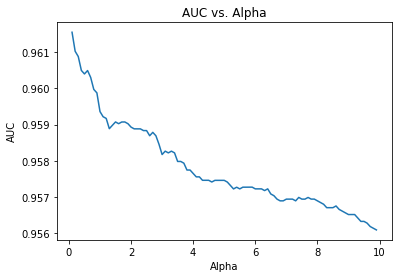

In [40]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha = i))
                 for i in np.arange(0.1, 10, 0.1)],
                index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9520
Accuracy: 90.41%


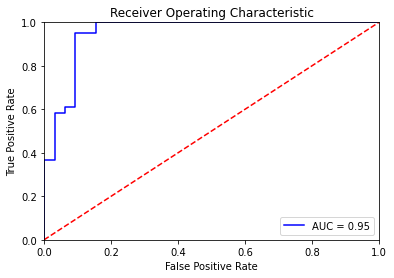

In [42]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(tfidf_train, y_train)
probs = nb_model.predict_proba(tfidf_validation)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [43]:
train_preds_nb = nb_model.predict(tfidf_train)
val_preds_nb = nb_model.predict(tfidf_validation)

train_f1_score_nb = f1_score(y_train, train_preds_nb)
val_f1_score_nb = f1_score(y_val, val_preds_nb)

train_accuracy_nb = accuracy_score(y_train, train_preds_nb)
val_accuracy_nb = accuracy_score(y_val, val_preds_nb)

In [44]:
print('Prediction accuracy for naive bayes model on train data:', round(train_accuracy_nb*100, 3))
print('Prediction accuracy for naive bayes model on validation data:', round(val_accuracy_nb*100, 3))

print()

print('F1 score for naive bayes model on train data:', round(train_f1_score_nb*100, 3))
print('F1 score for naive bayes model on validation data:', round(val_f1_score_nb*100, 3))

Prediction accuracy for naive bayes model on train data: 96.799
Prediction accuracy for naive bayes model on validation data: 90.411

F1 score for naive bayes model on train data: 97.158
F1 score for naive bayes model on validation data: 91.358


Naive bayes performed very similar, yet worse than logistic regression, the latter had an f1 score of 0.889.

To get an understanding of what algorithm fares better, we still need to test both of them on public test.

It's time to try out a crude LSTM model on our data now.

## TESTING

### Load and preprocess

In [45]:
test_df = pd.read_csv('../../public_test.csv')
x_test = test_df['article'].map(lemmatize)
tfidf_test = ngram_vectorizer.transform(x_test)

### Test with Logistic Regression

In [46]:

test_preds_lr = lr.predict(tfidf_test)
y_test = test_df['label']
f1_score(y_test, test_preds_lr)

0.916256157635468

### Test with Naive Bayes

In [47]:
test_preds_nb = nb_model.predict(tfidf_test)
f1_score(y_test, test_preds_nb)

0.9238578680203046